# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.0.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.1) Supervised Euclidean for LASTEN with fixed image
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/7_1_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/test'

path_fixed = r'D:\Julian\data\LASTEN\fix'
path_train = r'D:\Julian\data\LASTEN\train'
path_validation = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTEN\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=2

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen)
callbacks = [logger, checker, timelogger, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_metric = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_metric])

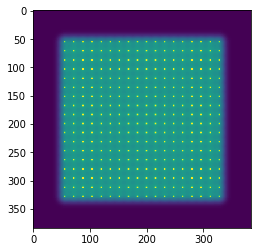

In [8]:
X, y = train_gen[0]

plt.imshow(X[0,:,:,1])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Train for 84 steps, validate for 18 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shap

84/84 [==============================] - 81s 960ms/step - loss: 1030.4792 - maed: 27.0839 - val_loss: 1692.7706 - val_maed: 36.4112
Epoch 2/100
84/84 [==============================] - 15s 177ms/step - loss: 449.7449 - maed: 17.5845 - val_loss: 1902.8280 - val_maed: 38.1990
Epoch 3/100
84/84 [==============================] - 15s 180ms/step - loss: 205.7367 - maed: 11.6792 - val_loss: 929.7053 - val_maed: 26.2920
Epoch 4/100
84/84 [==============================] - 15s 174ms/step - loss: 155.1189 - maed: 10.3084 - val_loss: 500.3039 - val_maed: 19.0461
Epoch 5/100
84/84 [==============================] - 15s 174ms/step - loss: 121.7116 - maed: 9.1027 - val_loss: 873.5213 - val_maed: 25.3583
Epoch 6/100
84/84 [==============================] - 15s 176ms/step - loss: 103.3962 - maed: 8.3934 - val_loss: 535.5607 - val_maed: 19.6393
Epoch 7/100
84/84 [==============================] - 15s 184ms/step - loss: 77.1127 - maed: 7.1608 - val_loss: 390.3723 - val_maed: 16.6378
Epoch 8/100
84/84 [

84/84 [==============================] - 15s 182ms/step - loss: 11.8783 - maed: 2.8286 - val_loss: 273.2377 - val_maed: 14.2806
Epoch 37/100
84/84 [==============================] - 15s 176ms/step - loss: 29.0117 - maed: 4.4085 - val_loss: 550.4663 - val_maed: 20.3515
Epoch 38/100
84/84 [==============================] - 15s 178ms/step - loss: 41.7815 - maed: 5.3148 - val_loss: 200.0632 - val_maed: 12.0202
Epoch 39/100
84/84 [==============================] - 15s 176ms/step - loss: 15.1392 - maed: 3.2060 - val_loss: 226.7144 - val_maed: 12.7136
Epoch 40/100
84/84 [==============================] - 15s 182ms/step - loss: 9.0766 - maed: 2.5114 - val_loss: 209.1968 - val_maed: 12.1071
Epoch 41/100
84/84 [==============================] - 15s 177ms/step - loss: 8.3213 - maed: 2.3924 - val_loss: 197.2506 - val_maed: 11.7995
Epoch 42/100
84/84 [==============================] - 15s 177ms/step - loss: 6.3457 - maed: 2.0664 - val_loss: 199.3226 - val_maed: 11.5613
Epoch 43/100
84/84 [=========

Epoch 72/100
84/84 [==============================] - 15s 177ms/step - loss: 7.0469 - maed: 2.1742 - val_loss: 216.4251 - val_maed: 12.3626
Epoch 73/100
84/84 [==============================] - 15s 175ms/step - loss: 6.8235 - maed: 2.1383 - val_loss: 190.9905 - val_maed: 11.4883
Epoch 74/100
84/84 [==============================] - 16s 188ms/step - loss: 9.7511 - maed: 2.6143 - val_loss: 242.5707 - val_maed: 12.9056
Epoch 75/100
84/84 [==============================] - 15s 178ms/step - loss: 8.0487 - maed: 2.2854 - val_loss: 193.1224 - val_maed: 11.3623
Epoch 76/100
84/84 [==============================] - 15s 178ms/step - loss: 15.4478 - maed: 3.2426 - val_loss: 207.6769 - val_maed: 12.0677
Epoch 77/100
84/84 [==============================] - 14s 172ms/step - loss: 7.0099 - maed: 2.1582 - val_loss: 186.4608 - val_maed: 11.4934
Epoch 78/100
84/84 [==============================] - 15s 175ms/step - loss: 6.2621 - maed: 2.0415 - val_loss: 183.2410 - val_maed: 11.2875
Epoch 79/100
84/84 

# Evaluation
Evaluate the trained network

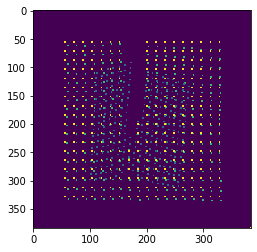

In [10]:
X, y = val_gen[3]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,324):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)